In [1]:
# Importing necessary packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import json

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from time import time

In [2]:
cores = 2

spark_session = SparkSession.builder\
        .master("spark://192.168.2.156:7077") \
        .appName("Group 6 project 2 cores")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", "2")\
        .config("spark.cores.max", 2)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.2.156:9000")\
        .getOrCreate()

sqlContext = SQLContext(spark_session.sparkContext)
spark_session.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/17 01:20:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# Load JSON as a Spark DataFrame
df = spark_session.read.json("hdfs://192.168.2.156:9000/data/reddit/corpus-webis-tldr-17.json")

In [4]:
# df.show() #Works!

# Task 1: Reading level in subreddits
First, we analyse the language level using Flesch–Kincaid grade level.

In [5]:
# Starting timer
t_start = time()

# Making a new df for analyzing the reading level

# Preprocessing

# Splitting sentences
df_spell = df.select("subreddit", split(df["content"], r'[.!?]').alias("content_split"))

# Splitting words, removing punctuation and empty strings
df_words = df_spell.withColumn("content_split", expr("""transform(content_split, x -> filter(transform(split(x, ' '), word -> trim(regexp_replace(regexp_replace(word, '[\\n]', ''), '[,\\.\\!\\?:\\*\\(\\)]', ''))), word -> word != ''))"""))

df_words = df_words.filter(size(df_words["content_split"]) > 3)  # Remove empty rows

df_words.first()
print(f"The length is {df_words.count()}")

[Stage 2:======================================================>(146 + 1) / 147]

The length is 3614537


In [6]:
# Define the syllable count function
def syllable_count(word):
    # If the word is not alphabetic, return 0 (e.g., for numbers or symbols)
    if not word.isalpha():
        return 0
    
    word = word.lower()  # Ensure the word is in lowercase
    count = 0
    vowels = "aeiou"
    
    # Check the first letter
    if word[0] in vowels:
        count += 1
    
    # Count syllables in the rest of the word
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    
    # Special case: Subtract 1 if the word ends with 'e' (unless 'e' is preceded by a vowel)
    if word.endswith("e") and (len(word) > 1 and word[-2] not in vowels):
        count -= 1
    
    # Ensure that a word has at least one syllable
    if count == 0:
        count += 1
    
    # Limit reasonable syllable count (this can be adjusted based on context)
    if count < 10:  # Reasonable cap for most English words
        return count
    else:
        return 1

# Define the function to calculate the reading level (Flesch-Kincaid)
def reading_level(list_of_sentences):
    # Flatten the list of lists into a single list of words

    total_words = 0
    total_syllables = 0
    total_sentences = 0  # Since each row represents one sentence (as split by punctuation)

    # Iterate over each word in the flattened list and calculate total words and syllables
    for sentence in list_of_sentences:
        
        words_in_sentence = 0
        syllables_in_sentence = 0
        
        # Iterate over each word in the sentence
        for word in sentence:
            # Skip empty strings or unwanted characters (e.g., newlines)
            word = word.strip(",. !?:*()[]")
            if word.isalpha():  # Ensure the word is alphabetic
                words_in_sentence += 1  # Increment word count
                syllables_in_sentence += syllable_count(word)  # Add syllables for the word
                
        if words_in_sentence > 0 and words_in_sentence < 35: # Only add reasonable values
            total_words += words_in_sentence
            total_syllables += syllables_in_sentence
            total_sentences += 1

    # Avoid division by zero
    if total_words == 0 or total_sentences == 0:
        return 0

    # Calculate the Flesch-Kincaid readability index with the formula:
    # Reading Level = 0.39 * (total_words / total_sentences) + 11.8 * (total_syllables / total_words) - 15.59
    level = 0.39*(total_words / total_sentences) + 11.8*(total_syllables / total_words) - 15.59
    if level < -3.5:
        raise ValueError(f"Level too low ({level}). Total words: {total_words}, Total sentences: {total_sentences}, Total syllables: {total_syllables}")
    else:
        return level

# # Define the UDF for reading level calculation
# def reading_level_udf(sentence_list):
#     return float(reading_level(sentence_list))

# Register the UDF
udf_reading_level = udf(lambda sentence_list: reading_level(sentence_list))

# Apply the UDF to calculate the reading level for each row
df_with_reading_level = df_words.withColumn("reading_level", udf_reading_level("content_split"))

# Show the result (debug)
df_with_reading_level.select("subreddit", "reading_level").show(truncate=False)

[Stage 5:>                                                          (0 + 1) / 1]

+---------------------+------------------+
|subreddit            |reading_level     |
+---------------------+------------------+
|math                 |11.549397590361448|
|funny                |8.003391304347826 |
|Borderlands          |7.165714285714287 |
|gamingpc             |8.757857142857144 |
|Diablo               |7.153531121109861 |
|RedditLaqueristas    |6.150692771084341 |
|apple                |12.878846153846155|
|apple                |6.8530126582278506|
|RedditFilmsProduction|5.902553719008267 |
|AbandonedPorn        |2.878922670191674 |
|atheism              |4.383823529411767 |
|AskReddit            |6.780000000000001 |
|personalfinance      |6.614189189189187 |
|Animals              |4.001194029850748 |
|leagueoflegends      |3.833307240704503 |
|AskReddit            |7.294487179487181 |
|videos               |7.1967662101963406|
|Games                |8.392061403508773 |
|AskReddit            |6.409752358490568 |
|AskReddit            |6.418271028037385 |
+----------

In [7]:
df_average_grade = df_with_reading_level.groupBy("subreddit").agg(avg("reading_level").alias("Avg_reading_level"))
# df_average_grade.show()

In [8]:
# Top 10 subreddits with the worst (lowest) reading level
top_10_best = df_average_grade.orderBy("avg_reading_level", ascending=True).limit(10)

# Top 10 subreddits with the best (highest) reading level
top_10_worst = df_average_grade.orderBy("avg_reading_level", ascending=False).limit(10)

print("Top 10 best Subreddits:")
top_10_worst.select("subreddit", "avg_reading_level").show(truncate=False)

print("Top 10 worst Subreddits:")
top_10_best.select("subreddit", "avg_reading_level").show(truncate=False)

t_end = time()
time_taken = t_end - t_start

print(f"Total time taken: {time_taken}\nCores used: {cores}")

Top 10 best Subreddits:


+------------------+------------------+
|subreddit         |avg_reading_level |
+------------------+------------------+
|tppanalysis       |19.234366197183103|
|acceptbitcoin     |18.493529411764708|
|helsinki          |16.916975308641977|
|pelit             |16.50067567567567 |
|Suomi             |16.094416312144713|
|podtest_6feb15    |15.824577067669178|
|AskRo             |15.60727272727273 |
|pointedblack      |15.51886363636364 |
|HaloClans         |15.469999999999999|
|explainlikeimspock|15.389793577981653|
+------------------+------------------+

Top 10 worst Subreddits:


[Stage 9:=======================================================(147 + 0) / 147]

+------------------+-------------------+
|subreddit         |avg_reading_level  |
+------------------+-------------------+
|theoryofpropaganda|-3.3999999999999986|
|chipcards         |-3.3999999999999986|
|discoverynews     |-3.3999999999999986|
|exinferno         |-3.01              |
|Retrogamingmusic  |-3.01              |
|brains            |-3.01              |
|Essay             |-2.8149999999999995|
|IAMGROOT          |-2.619999999999999 |
|ggggg             |-2.619999999999999 |
|EchJokes          |-2.5333333333333314|
+------------------+-------------------+

Total time taken: 3233.8415570259094
Cores used: 2


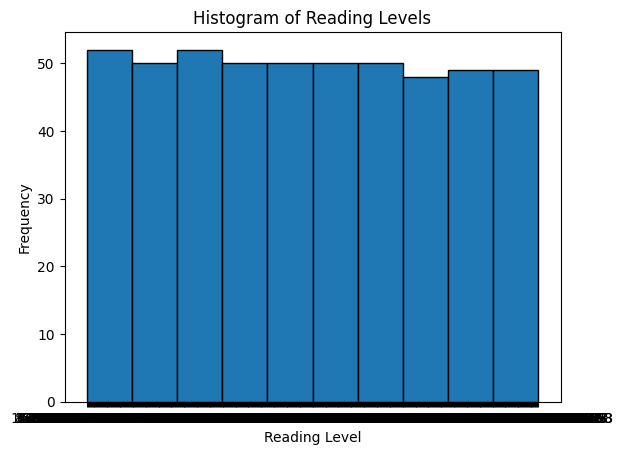

In [9]:
pdf = df_with_reading_level.select("reading_level").limit(500).toPandas()

import matplotlib.pyplot as plt
# Plot histogram
plt.hist(pdf["reading_level"], edgecolor="black")
plt.xlabel("Reading Level")
plt.ylabel("Frequency")
plt.title("Histogram of Reading Levels")
plt.show()

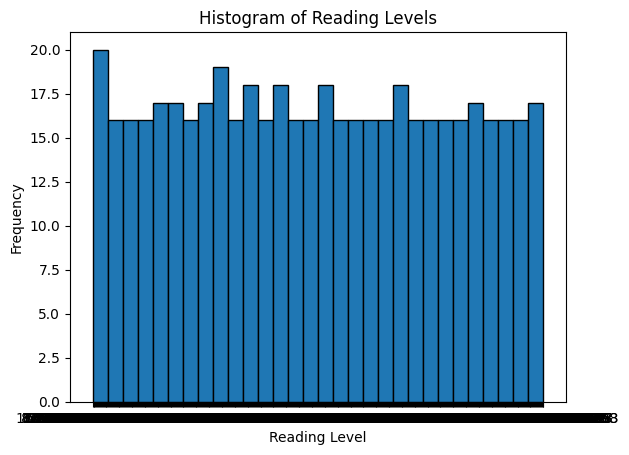

In [10]:

# Plot histogram
plt.hist(pdf["reading_level"], bins=30, edgecolor="black")
plt.xlabel("Reading Level")
plt.ylabel("Frequency")
plt.title("Histogram of Reading Levels")
plt.show()

In [11]:
webkins = df.where("subreddit" == "Webkinz")
webkins.show()

PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `condition` should be a Column or str, got bool.

In [ ]:
spark_session.stop()